(50, 50, 2)
2502
534.1


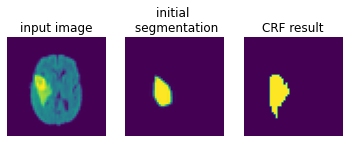

In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict as ddict
from math import exp, log

INF = 1e10
SCALE = 1e1
dirs = ((-1, 0), (0, -1))

def bfs(adj, capacity, s, t, parent):
	for i in range(len(parent)):
		parent[i] = -1
	parent[s]=-2;
	queue = []
	queue.append((s, INF))

	while len(queue) > 0:
		u = queue[0][0]
		flow = queue[0][1]

		queue.pop(0)

		for v in adj[u]:
			if parent[v] == -1 and capacity[u][v] > 0:
				parent[v] = u
				new_flow = min(flow, capacity[u][v])
				if v == t:
					return new_flow
				else:
					queue.append((v, new_flow))


	return 0
def dfs(adj, capacity, u, cut, visited):
	visited[u] = True
	if u < len(adj)-2:
		cut[u] = 1.0

	for v in adj[u]:
		if not visited[v] and capacity[u][v] > 0:
			dfs(adj, capacity, v, cut, visited)

def getsource(adj, capacity, s, cut):
	visited = [False] * len(adj)
	dfs(adj, capacity, s, cut, visited)

def maxflow(adj, capacity, s, t, n):
	flow = 0
	parent = [0]*n

	while True:
		new_flow = bfs(adj, capacity, s, t, parent)
		flow += new_flow

		if new_flow == 0:
			break

		curr = t
		while curr != s:
			prev = parent[curr]
			capacity[prev][curr] -= new_flow
			capacity[curr][prev] += new_flow
			curr = prev
	return flow


def inference(image, mask):
	lamda = 20.0
	sigma = 10.0

	P = image / 255
	fP = 0.5 + (P-0.5) * 0.8
	bP = 1.0 - fP
	prob = np.asarray([bP, fP])
	prob = np.transpose(prob, [1,2,0])
	print(prob.shape)

	h,w = image.shape
	n = h*w + 2
	s = n-2
	t = n-1

	max_weight = -INF

	adj = [[] for _ in range(n)]
	capacity = [ddict(lambda:0) for _ in range(n)]
	# capacity = [{} for _ in range(n)]

	for i in range(h):
		for j in range(w):
			pi = image[i][j]
			for d in dirs:
				ii = i + d[0]
				jj = j + d[1]
				if ii < 0 or jj < 0:
					continue
				qi = image[ii][jj]
				l2dis = abs(pi-qi)
				n_weight = lamda*exp(-l2dis*l2dis/(2*sigma*sigma))
				n_weight_int = int(n_weight*SCALE)
				adj[i*w+j].append(ii*w+j)
				adj[ii*w+j].append(i*w+j)
				capacity[i*w+j][ii*w+j]=n_weight_int
				capacity[ii*w+j][i*w+j]=n_weight_int
				max_weight = max(max_weight, n_weight_int)

	
	max_weight = SCALE * max_weight

	for i in range(h):
		for j in range(w):
			
			p = prob[i][j]
			
			s_weight = -log(p[0])
			t_weight = -log(p[1])
			
			adj[s].append(i*w+j)
			capacity[s][i*w+j]=int(s_weight*SCALE)
			capacity[i*w+j][s]=0
			
			adj[i*w+j].append(t)
			capacity[i*w+j][t]=int(t_weight*SCALE)
			capacity[t][0]=0

	print(n)
	# print(capacity)
	print(maxflow(adj, capacity, s, t, n)/SCALE)

	label = np.zeros(h*w, dtype=np.float32)
	getsource(adj, capacity, s, label)
	return label.reshape(h,w)



if __name__ == '__main__':
	image = Image.open('brain.png').convert('L')
	image = np.asarray(image.resize((50, 50), Image.ANTIALIAS), dtype=np.float32)
	# image = np.asarray(image, dtype=np.float32)

	mask = Image.open('brain_mask.png').convert('L')
	mask = np.asarray(mask.resize((50, 50), Image.ANTIALIAS),dtype=np.float32)

	label=inference(image,mask)
	plt.subplot(1,3,1); plt.axis('off'); plt.imshow(image);  plt.title('input image')
	plt.subplot(1,3,2); plt.axis('off'); plt.imshow(mask);   plt.title('initial \n segmentation')
	plt.subplot(1,3,3); plt.axis('off'); plt.imshow(label); plt.title('CRF result')
	plt.show()